<a href="https://colab.research.google.com/github/rajy4683/EVA4/blob/master/EVA4RFUtils.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Visualizing Receptive Field.
#### This notebook is currently used to visualize the receptive field for MNIST dataset. It can be adapted for CIFAR/other datasets. Make sure you use the right channels.
#### Main libraries are used from https://github.com/fornaxai/receptivefield
#### Core model taken from EVA4 Session 5....Thanks to Rohan Shravan

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
!pip install torchsummary
from torchsummary import summary
import pandas as pd
import numpy as np

In [0]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [0]:
!pip install receptivefield>=0.5.0


In [0]:
from receptivefield.pytorch import PytorchReceptiveField
from receptivefield.image import get_default_image

In [0]:
!pip install git+https://github.com/microsoft/tensorwatch

In [0]:
import tensorwatch as tw

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

CUDA Available? False
torch.Size([64, 1, 28, 28])
torch.Size([64])


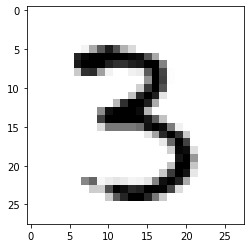

In [9]:
SEED = 100

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

for i in range(10):
    plt.imshow(images[i].numpy().squeeze(), cmap='gray_r')


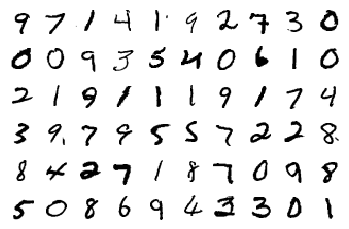

In [10]:
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## Model specification. 
#### Specify the layers for which visualization is required in "self.select"


In [0]:
class Linear(nn.Module):
    """An identity activation function"""
    def forward(self, x):
        return x
# define some example feature extractor, here we compute RFs for two 
# feature maps

dropout_value = 0.1
class NetLocal(nn.Module):
    def __init__(self, disable_activations: bool = False, select_layers=[0]):
        """disable_activations: whether to generate network with Relus or not."""
        super(NetLocal, self).__init__()
        self.features = self._make_layers(disable_activations)
        self.dropout_val = 0.1
        self.select = select_layers #### The index of feature maps for which receptive field needs to be evaluated

    def forward(self, x):
        # Index of all the Layers for which Receptive field is needed.
        select = self.select
        # self.feature_maps is a list of Tensors, PytorchReceptiveField looks for 
        # this parameter and compute receptive fields for all Tensors inside it.
        self.feature_maps = []
        for l, layer in enumerate(self.features):
            x = layer(x)
            if l in select:
                self.feature_maps.append(x)                
                #print(type(x))
        return x
    
    """ 
        Define your model as a list of various modules and 
        call nn.Sequential on the model to create the model during object 
        instantiation
        Below model is taken from EVA4 Session5....Big thanks to Rohan Shravan
    """
    def _make_layers(self, disable_activations: bool):
        activation = lambda: Linear() if disable_activations else nn.ReLU()
        layers = [            
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0), #### Dont add bias=False in the first layer
            #nn.Conv2d(1, 16,  3, 1, padding=0),
            nn.ReLU(),          
            nn.BatchNorm2d(16),
            
            nn.Dropout(dropout_value),
            #nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.Conv2d(16, 32, 3, padding=0, bias=False),            
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value),
            # TRANSITION BLOCK 1
            #nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.Conv2d(32, 10, 1, padding=0, bias=False),
            nn.MaxPool2d(2, 2), # output_size = 12

            #nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.Conv2d(10, 16, 3, padding=0, bias=False),
            nn.ReLU(),       
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.Conv2d(16, 16, 3, padding=0, bias=False),
            #nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            # nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.Conv2d(16, 16, 3, padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            # nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.Conv2d(16, 16, 3, padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),        
            # #OUTPUT BLOCK         
            nn.AvgPool2d(kernel_size=6),
            # nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.Conv2d(16, 10, 1, padding=0, bias=False),
        ]        
        return nn.Sequential(*layers)   

In [12]:
current_model = NetLocal(select_layers=[0,4,18,22]).to(device)
summary(current_model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 32, 24, 24]           4,608
              ReLU-6           [-1, 32, 24, 24]               0
       BatchNorm2d-7           [-1, 32, 24, 24]              64
           Dropout-8           [-1, 32, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             320
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,440
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1, 16,

In [0]:
def model_fn() -> nn.Module:
    model = current_model #### pass the model created above
    model.eval()
    return model

#### The core receptive field visualization. 
#### Please note that the 2nd parameter for the "layout" should be the size of the feature maps selected in your model.
##### In the below cell, we are checking for layers[0,4,19,22]

[2020-02-13 18:04:02,405][ INFO][pytorch.py]::Feature maps shape: [GridShape(n=1, w=26, h=26, c=16), GridShape(n=1, w=24, h=24, c=32), GridShape(n=1, w=8, h=8, c=16), GridShape(n=1, w=6, h=6, c=16)]
[2020-02-13 18:04:02,406][ INFO][pytorch.py]::Input shape       : GridShape(n=1, w=28, h=28, c=1)
[2020-02-13 18:04:02,492][ INFO][base.py]::Estimated receptive field for feature map [0]: ReceptiveFieldDescription(offset=(1.5, 1.5), stride=(1.0, 1.0), size=Size(w=3, h=3))
[2020-02-13 18:04:02,493][ INFO][base.py]::Estimated receptive field for feature map [1]: ReceptiveFieldDescription(offset=(2.5, 2.5), stride=(1.0, 1.0), size=Size(w=5, h=5))
[2020-02-13 18:04:02,494][ INFO][base.py]::Estimated receptive field for feature map [2]: ReceptiveFieldDescription(offset=(6.5, 6.5), stride=(2.0, 2.0), size=Size(w=17, h=17))
[2020-02-13 18:04:02,496][ INFO][base.py]::Estimated receptive field for feature map [3]: ReceptiveFieldDescription(offset=(8.5, 8.5), stride=(2.0, 2.0), size=Size(w=21, h=21))

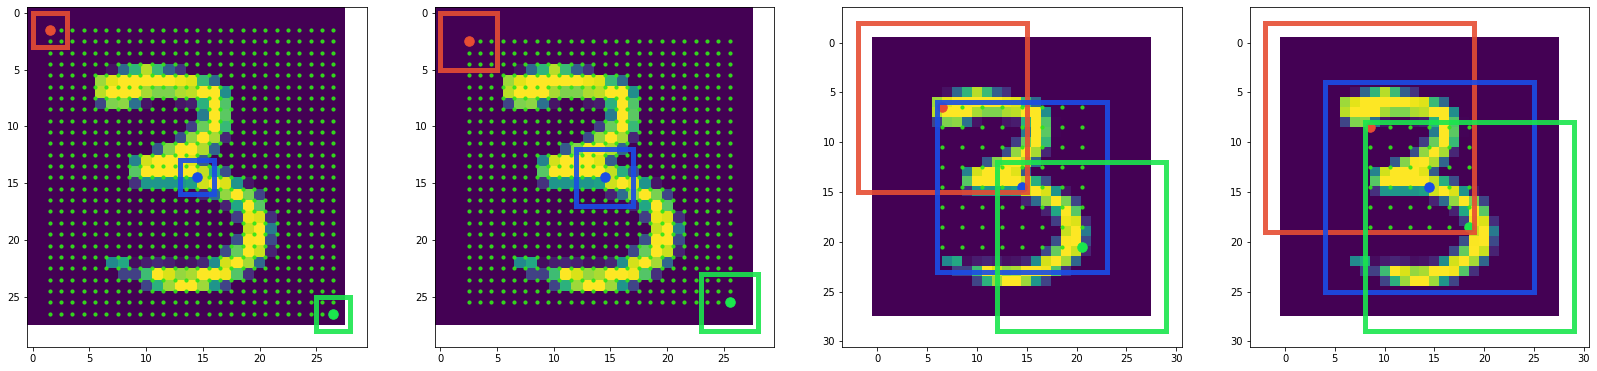

In [14]:
input_shape = [28, 28, 1]
rf = PytorchReceptiveField(model_fn)
rf_params = rf.compute(input_shape = input_shape)
# plot receptive fields
rf.plot_rf_grids(
    custom_image=images[9].numpy().squeeze(),
    figsize=(28, 28), 
    layout=(1, len(current_model.select)))